In [1]:
import sys
import csv
import os
import shutil
import pandas as pd
import numpy as np
import decimal
from pyneuroml import pynml
from pyneuroml.pynml import print_comment_v
from pyneuroml.lems import LEMSSimulation

import neuroml as nml
import neuroml.writers as writers
from neuroml.utils import validate_neuroml2
import random
random.seed(12345)
from neuroml.nml.nml import parse as nmlparse
import eden_tools
dir(eden_tools)

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
os.getcwd()


/opt/conda/lib/python3.7/site-packages/airspeed/__init__.py:505: FutureWarning: Possible nested set at position 8
  KEYVALSEP = re.compile(r'[ \t]*:[[ \t]*(.*)$', re.S)


'/home/jovyan/work/NeuroML_Examples/Rocher'

## Choose which channel you want to examine

Ugly but functional code ¯\\_(ツ)_/¯ to set the parameters how you like. 
The morphologies are read from Another_Cells folder, parameters adjusted and then saved to the Cells folder which is used for running the simulations.



In [2]:
path = os.getcwd()
Temp = 37
#net_id = "network_of_%s"%cell_id    
#net_doc = nml.NeuroMLDocument(id='net_'+str(cell_id))
results = []
channel_dict = dict(na_s_soma=0, kdr_soma=1, k_soma=2, cal_soma=3, BK_soma=4, cah_dend=5, kca_dend=6, h_dend=7, cacc_dend=8, na_axon=9, k_axon=10)
sim_id = 'Test'
cellnames = open('cell_list_sorted.txt', 'r')
content = cellnames.read()
filenames = content.split("\n")
cellnames.close()
print(filenames)

['C25C', 'C16', 'C51D', 'C25A', 'C32B', 'C46A', 'C50A', 'C4A', 'C11A', 'C51A', 'C48', 'C20A', 'C28B', 'C31', 'C51B', 'C21A', 'C49A', 'C1A', 'C50B', 'C51C', 'C49C', 'C45A', 'C21B', 'C15A', 'C6A', 'C49B', 'C23']


In [3]:
for f in range(len(filenames)):
    cell_id = filenames[f]
    os.remove('./pynmlNetworks/nml_'+cell_id+'.net.nml')
    os.remove('./LEMSFILES/LEMS_'+str(sim_id)+'_'+str(cell_id)+'.xml')

In [239]:
for f in range(len(filenames)):
    cell_id = filenames[f]
    net_id = "network_of_%s"%cell_id    
    net_doc = nml.NeuroMLDocument(id='net_'+str(cell_id))

    #include cell file from ../Cells/
    cellfile = nml.IncludeType(href='../Cells/'+cell_id+'_scaled_exp_resample_5.cell.nml')
    net_doc.includes.append(cellfile)

    #create network
    net = nml.Network(id=net_id, type="networkWithTemperature", temperature=str(Temp)+"degC")
    net_doc.networks.append(net)

    #create population
    pop = nml.Population(id='population_of_%s'%cell_id,component=cell_id,type='populationList',size='1')
    net.populations.append(pop)

    loc = nml.Location(x='0',y='0',z='0')
    inst = nml.Instance(id='0',location=loc)
    pop.instances.append(inst)

    #include current clamp 
    t_delay = 0
    t_duration = 50
    Amp = '-2.5nA'

    Iclamp0 = nml.PulseGenerator(id='iclamp0',delay=str(t_delay)+'ms',duration=str(t_duration)+'ms', amplitude=Amp)
    net_doc.pulse_generators.append(Iclamp0)

    Iclamp1 = nml.PulseGenerator(id='iclamp1',delay=str(t_delay)+'ms',duration=str(t_duration)+'ms', amplitude=Amp)
    net_doc.pulse_generators.append(Iclamp1)


    #add Iclamp to cell
    #input_list = nml.InputList(id='Iclamp0', component=Iclamp0.id, populations=pop.id)
    #input = nml.Input(id='0', target = "../%s/0/"%(pop.id)+str(cell_id), segmentId="0", destination="synapses")
    #input_list.input.append(input)
    #net.input_lists.append(input_list)

    input_list = nml.InputList(id='Iclamp1', component=Iclamp1.id, populations=pop.id)
    input = nml.Input(id='0', target = "../%s/0/"%(pop.id)+str(cell_id), segmentId="0", destination="synapses")
    input_list.input.append(input)
    input = nml.Input(id='1', target = "../%s/0/"%(pop.id)+str(cell_id), segmentId="0", destination="synapses")
    input_list.input.append(input)
    net.input_lists.append(input_list)



    #write the network file
    net_file_name = 'nml_'+cell_id+'.net.nml'
    writers.NeuroMLWriter.write(net_doc,net_file_name)
    shutil.move(path+'/'+str(net_file_name), path+'/pynmlNetworks')
    validate_neuroml2('./pynmlNetworks/nml_'+cell_id+'.net.nml')

    #redefine net and cell in case you don't run the above code segment
    sim_id = 'Test'
    length = 800
    step = 0.025

    #dend_channel = ["cah_dend/cah/r/q", "kca_dend/kca/z/q", "h_dend/h/n/q", "cacc_dend/cacc/m/q"]
    #axon_channel = ["na_axon/na_a/m/q", "na_axon/na_a/h/q", "k_axon/k/n/q"]
    soma_channel = ["na_s_soma/na_s/m/q", "na_s_soma/na_s/h/q", "kdr_soma/kdr/n/q", "k_soma/k/n/q", "cal_soma/cal/k/q", "cal_soma/cal/l/q", "BK_soma/BK/c/q"]
    recorded_segment = 0
    recorded_segment1 = 10
    recorded_segment2 = 69
    recorded_segment3 = 0
    recorded_variable1 = "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment1)+"/v"
    recorded_variable2 = "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment2)+"/v"
    recorded_variable3 = "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment3)+"/v"

    nmlfile = './pynmlNetworks/nml_'+cell_id+'.net.nml'  #include_neuroml2_file duplicates the path if you use path+ and does not find the file if you use ../
    LEMS = LEMSSimulation(sim_id, length , step , target = "network_of_%s"%cell_id)
    LEMS.include_neuroml2_file(nmlfile)
    LEMS.set_report_file('SimStat.txt')                                   # not necessary but out of interest to see EDEN vs NEURON 




    #disp_0 = 'Voltage'
    #LEMS.create_display(disp_0, 'Voltage trace', '-100', '70' )
    #LEMS.add_line_to_display(disp_0, recorded_segment, recorded_variable)

    #traces0 = 'voltage traces'
    #LEMS.create_output_file(traces0,"%s.v.dat"%sim_id)
    #LEMS.add_column_to_output_file(traces0, recorded_segment, recorded_variable)
    disp1 = 'Gates Dendrite'
    disp2 = 'Gates Axon'
    disp = 'Gates Soma'
    traces1 = 'Gate_file_dendrite'
    traces2 = 'Gate_file_axon'
    traces = 'Gate_file_soma'

    LEMS.create_display(disp, "Soma gate variables", "0", "1")
    LEMS.create_output_file(traces, "%s.Soma_gates.dat"%sim_id)

    #LEMS.create_display(disp1, "Dendrite gate variables", "0", "1")
    #LEMS.create_output_file(traces1, "%s.Dendrite_gates.dat"%sim_id)

    #LEMS.create_display(disp2, "Axon gate variables", "0", "1")
    #LEMS.create_output_file(traces2, "%s.Axon_gates.dat"%sim_id)

    #for i in range(len(dend_channel)):
        #disp1 = 'Gates Dendrite'
        #LEMS.create_display(disp1, "Dendrite gate variables", "0", "1")
     #   LEMS.add_line_to_display(disp1, recorded_segment1, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment1)+"/biophys/membraneProperties/"+str(dend_channel[i]))

        #traces1 = 'Gate_file_dendrite'
        #LEMS.create_output_file(traces1, "%s.gates.dat"%sim_id)
     #   LEMS.add_column_to_output_file(traces1, recorded_segment1, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment1)+"/biophys/membraneProperties/"+str(dend_channel[i]))

    #for i in range(len(axon_channel)):
        #disp2 = 'Gates Axon'
        #LEMS.create_display(disp1, "Dendrite gate variables", "0", "1")
      #  LEMS.add_line_to_display(disp2, recorded_segment2, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment2)+"/biophys/membraneProperties/"+str(axon_channel[i]))

        #traces2 = 'Gate_file_axon'
        #LEMS.create_output_file(traces1, "%s.gates.dat"%sim_id)
     #   LEMS.add_column_to_output_file(traces2, recorded_segment2, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment2)+"/biophys/membraneProperties/"+str(axon_channel[i]))   

    #for i in range(len(soma_channel)):
        #disp2 = 'Gates Axon'
        #LEMS.create_display(disp1, "Dendrite gate variables", "0", "1")
       # LEMS.add_line_to_display(disp, recorded_segment, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment)+"/biophys/membraneProperties/"+str(soma_channel[i]))

        #traces2 = 'Gate_file_axon'
        #LEMS.create_output_file(traces1, "%s.gates.dat"%sim_id)
       # LEMS.add_column_to_output_file(traces, recorded_segment, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment)+"/biophys/membraneProperties/"+str(soma_channel[i]))        



    disp4 = 'Soma Voltage'
    LEMS.create_display(disp4, "Dendrite trace", "-100", "70")
    LEMS.add_line_to_display(disp4, recorded_segment3, recorded_variable3)
    
    traces4 = 'Soma file'
    LEMS.create_output_file(traces4, "%s.vd.dat"%cell_id)
    LEMS.add_column_to_output_file(traces4, recorded_segment3, recorded_variable3)
    

    #traces5 = 'Caconc file'
    #LEMS.create_output_file(traces5, "%s.caconc.dat"%sim_id)
    #LEMS.add_column_to_output_file(traces5, recorded_segment1, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(recorded_segment1)+"/caConc")
    #LEMS.add_column_to_output_file(traces5, 4, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(4)+"/caConc")
    #LEMS.add_column_to_output_file(traces5, 2, "%s/0/"%(pop.id)+str(cell_id)+"/"+str(2)+"/caConc")




    filename = 'LEMS_'+str(sim_id)+'_'+str(cell_id)+'.xml'
    LEMS.save_to_file(file_name = filename )

    #edit the wrong path generated by LEMS.include_neuroml2_file
    fin = open(path+'/'+str(filename), 'rt')
    data = fin.read()
    data = data.replace('<Include file="./pynmlNetworks/', '<Include file="../pynmlNetworks/')
    data = data.replace('ExpTime.nml', '../channels/ExpTime.nml')    # patch up for wrong path generated in network script
    fin.close()
    fin = open(path+'/'+str(filename), 'wt')
    fin.write(data)
    fin.close()

    shutil.move(path+'/'+str(filename), path+'/LEMSFILES')




Error: Destination path '/home/jovyan/work/NeuroML_Examples/Rocher/pynmlNetworks/nml_C25C.net.nml' already exists

In [240]:
channel_dict = dict(na_s_soma=0, kdr_soma=1, k_soma=2, cal_soma=3, BK_soma=4, cah_dend=5, kca_dend=6, h_dend=7, cacc_dend=8, na_axon=9, k_axon=10)
results = []
#parameter = []


parameter = 0.0
chosen_channel = 'cacc_dend'
results = []

na_s_soma =[30]   #default 30
kdr_soma=[30]    #default 30
k_soma=[15]      #default 15
cal_soma=[80] #default 20
BK_soma=[0] #default 0 :) 

#set dendritic channel densities
cah_dend=[10]   #default 10
kca_dend=[200]   #default 35
h_dend=[25]       #default 25
cacc_dend = [0] #default 0.7

#set axonic channel densities
na_axon=[200,200,200,200,200]     #default 200
k_axon=[200,200,200,200,200]      #default 200


for g in range(len(filenames)):
        
            
    cell_id = filenames[g]
    filename = 'LEMS_'+str(sim_id)+'_'+str(cell_id)+'.xml'
    LEMS_file = f'LEMSFILES/{filename}'
    doc = nmlparse('Another_Cells/'+cell_id+'_scaled_exp_resample_5.cell.nml')
    #doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict[chosen_channel]].cond_density = str(parameter[g])+' mS_per_cm2'
    #writers.NeuroMLWriter.write(doc, 'Cells/'+cell_id+'_scaled_exp_resample_5.cell.nml')
    
    #somatic channel densities
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['na_s_soma']].cond_density = str(na_s_soma[0])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['kdr_soma']].cond_density = str(kdr_soma[0])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['k_soma']].cond_density = str(k_soma[0])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['cal_soma']].cond_density = str(cal_soma[0])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['BK_soma']].cond_density = str(BK_soma[0])+' mS_per_cm2'
    
    #dendritic channel densities    
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['cah_dend']].cond_density = str(cah_dend[0])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['kca_dend']].cond_density = str(kca_dend[0])+' mS_per_cm2'    
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['h_dend']].cond_density = str(h_dend[0])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['cacc_dend']].cond_density = str(cacc_dend[0])+' mS_per_cm2'
    
    #axonic channel densities
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['na_axon']].cond_density = str(na_axon[0])+' mS_per_cm2'
    doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['k_axon']].cond_density = str(k_axon[0])+' mS_per_cm2'
    
    #leak channel
    #doc.cells[0].biophysical_properties.membrane_properties.channel_densities[channel_dict['leak']].cond_density = str(leak[g])+' mS_per_cm2'
    writers.NeuroMLWriter.write(doc, 'Cells/'+cell_id+'_scaled_exp_resample_5.cell.nml')
 

    #out_dir = path+'\Simulation result'
    out_dir,rel_filename = os.path.split(LEMS_file)
    print(out_dir)
    print(rel_filename)



    print(f'You are running a simulation of {LEMS_file} and saving the results to {out_dir}\n')

    #results = {}
    #results = pynml.run_lems_with_jneuroml_neuron(
    #        LEMS_file, verbose=False, nogui=True, load_saved_data=True, exec_in_dir= out_dir,
    #        max_memory='1000M')


    #results_Eden = eden_tools.runEden( LEMS_file, verbose=True )
    results_Neuron = eden_tools.runNeuron( LEMS_file, verbose=True )
    results.append(dict(results_Neuron))

LEMSFILES
LEMS_Test_C25C.xml
You are running a simulation of LEMSFILES/LEMS_Test_C25C.xml and saving the results to LEMSFILES

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C25C.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES/LEMS_Test_C25C.xml), base_dir: LEMSFILES, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 2.26 seconds
LEMSFILES
LEMS_Test_C16.xml
You are running a simulation of LEMSFILES/LEMS_Test_C16.xml and saving the results to LEMSFILES

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C16.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES/LEMS_Test_C16.xml), base_dir: LEMSFILES, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 2.28 seconds
LEMSFILES
LEMS_Test_C51D.xml
You are running a simulation of LEMSFILES/LEMS_Test_C51D.xml and saving the results to LEMSFILES

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C51D.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILE

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C21B.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES/LEMS_Test_C21B.xml), base_dir: LEMSFILES, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 2.76 seconds
LEMSFILES
LEMS_Test_C15A.xml
You are running a simulation of LEMSFILES/LEMS_Test_C15A.xml and saving the results to LEMSFILES

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C15A.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES/LEMS_Test_C15A.xml), base_dir: LEMSFILES, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 3.22 seconds
LEMSFILES
LEMS_Test_C6A.xml
You are running a simulation of LEMSFILES/LEMS_Test_C6A.xml and saving the results to LEMSFILES

pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Test_C6A.xml (/home/jovyan/work/NeuroML_Examples/Rocher/LEMSFILES/LEMS_Test_C6A.xml), base_dir: LEMSFILES, cwd: /home/jovyan/work/NeuroML_Examples/Rocher
Ran jNeuroML_NEURON in 2.93 seconds


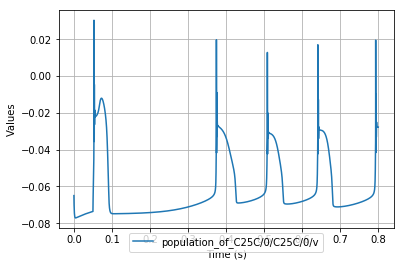

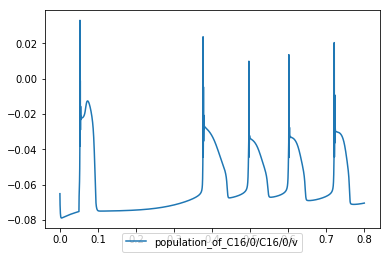

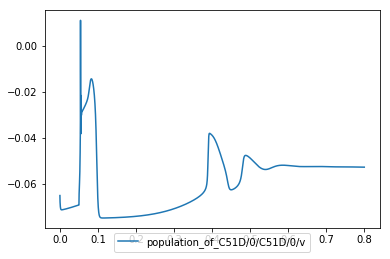

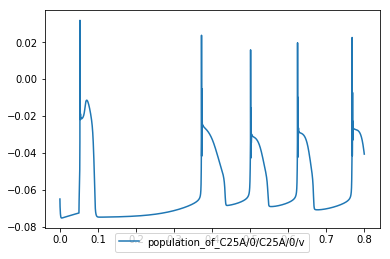

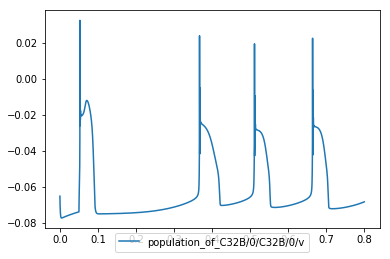

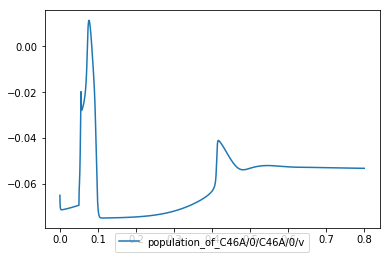

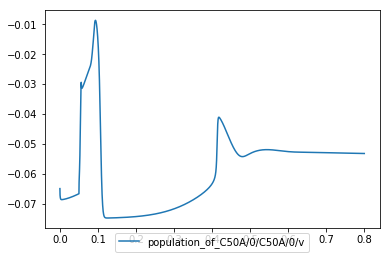

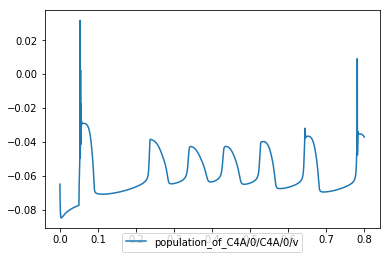

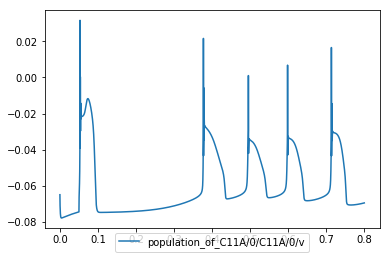

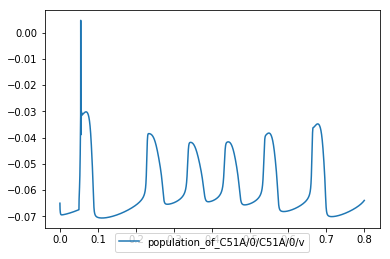

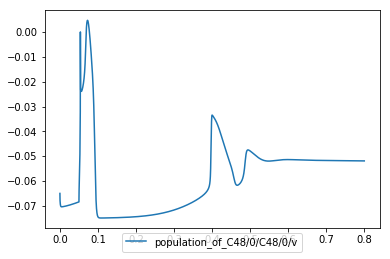

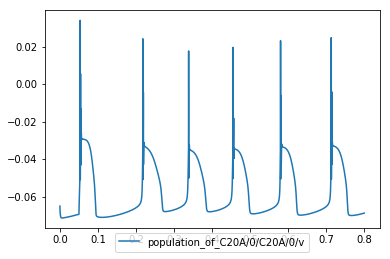

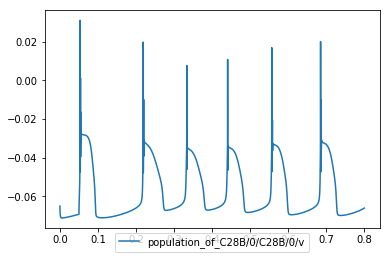

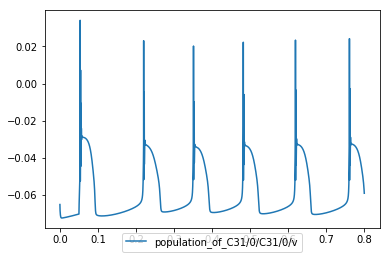

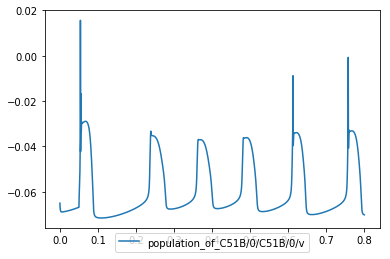

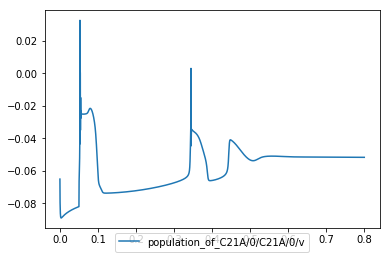

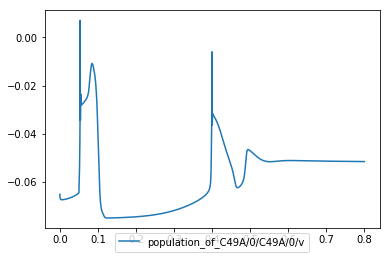

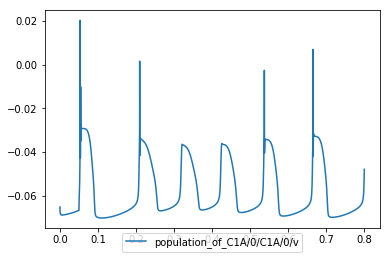

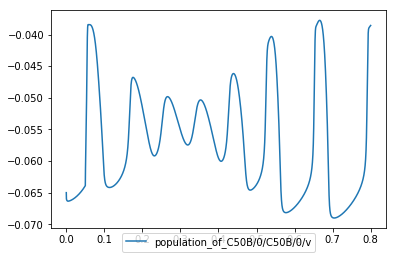

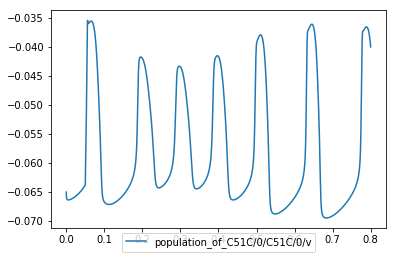

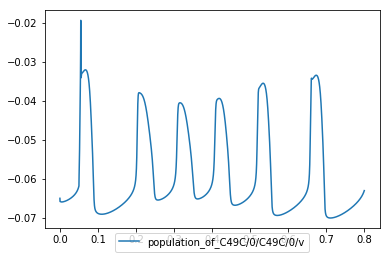

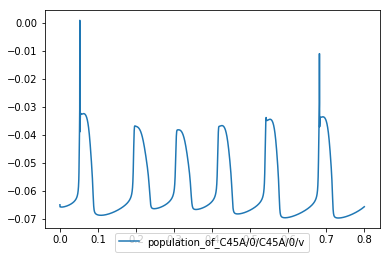

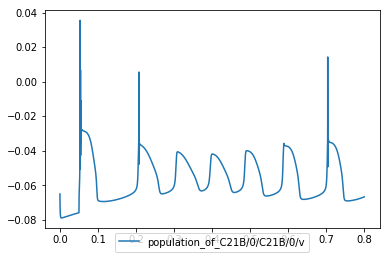

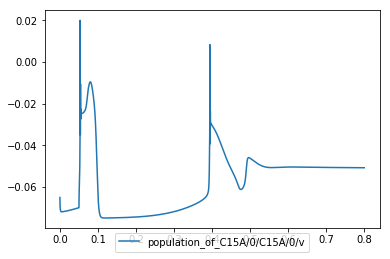

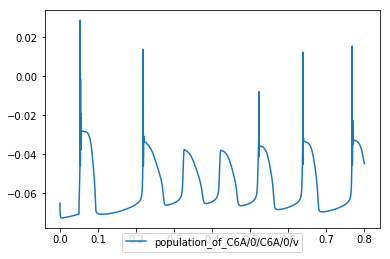

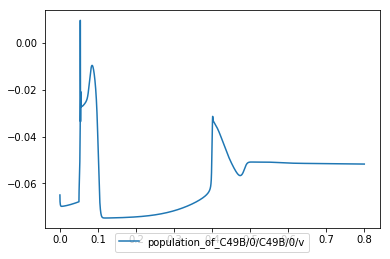

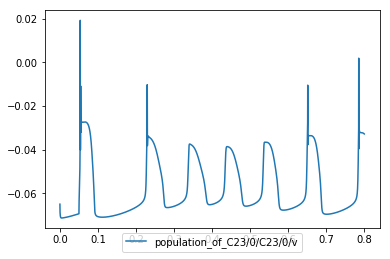

In [241]:

plt.xlabel('Time (s)')
plt.ylabel('Values')
plt.grid(True)

# plt.gca().clear()

for i in range(len(results)):

    for key in results[i]:
        results_Neuron = results[i]
        if key == 't':
            # no need to plot sim time against sim time
            continue
        plt.plot(results_Neuron['t'],results_Neuron[key], label=""+key)

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0))
    plt.show()


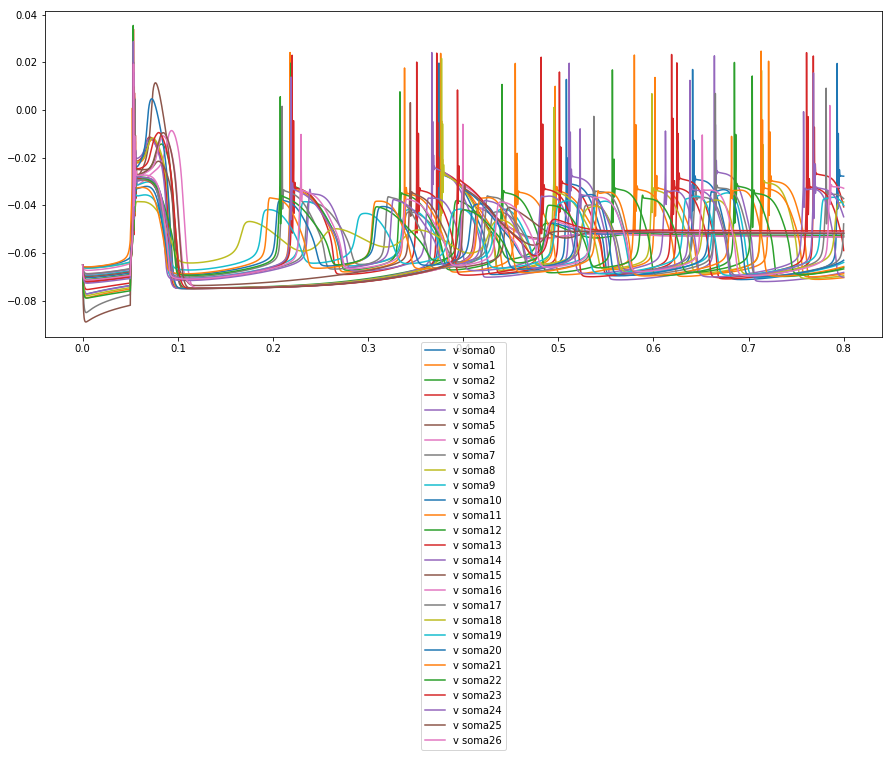

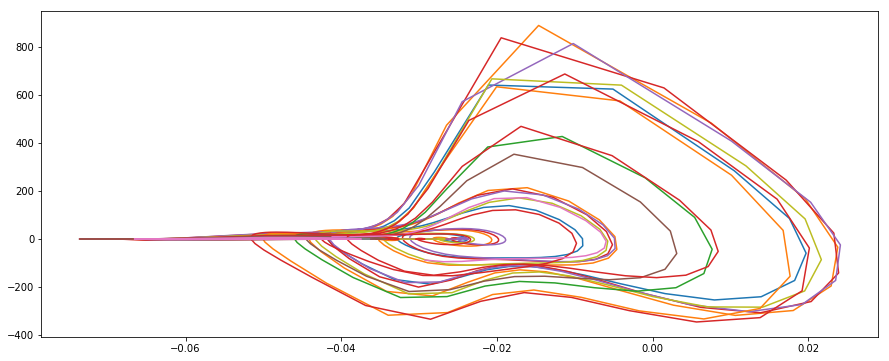

KeyError: 'population_of_C25C/0/C25C/10/caConc'

<Figure size 1080x432 with 0 Axes>

In [242]:
from numpy import diff

for g in range(len(results)):
    results_Neuron = results[g]
    cell_id = filenames[g]
    plt.figure(5, figsize=(15,6))
    plt.plot(results_Neuron['t'], results_Neuron['population_of_'+str(cell_id)+'/0/'+str(cell_id)+'/0/v'], label = "v soma"+str(g))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0))
plt.show() 


plt.figure(5, figsize=(15,6))
for g in range(len(results)):
    dx = 0.025*(10**-3)
    results_Neuron = results[g]
    cell_id = filenames[g]
    y = results_Neuron['population_of_'+str(cell_id)+'/0/'+str(cell_id)+'/0/v']
    dy = diff(y)/dx
    plt.plot(y[10000:16000],dy[10000:16000])
    
plt.show()



plt.figure(7, figsize=(15,6))
for g in range(len(results)):
    results_Neuron = results[g]
    cell_id = filenames[g]
    if max(results_Neuron[f'population_of_{cell_id}/0/{cell_id}/10/caConc']) != 0.0:
        plt.plot(results_Neuron['t'],results_Neuron[f'population_of_{cell_id}/0/{cell_id}/10/caConc'], label = "caConc dendrite 10"+str(cell_id))
    elif max(results_Neuron[f'population_of_{cell_id}/0/{cell_id}/4/caConc']) !=0.0:
        plt.plot(results_Neuron['t'],results_Neuron[f'population_of_{cell_id}/0/{cell_id}/4/caConc'], label = "caConc dendrite 4"+str(cell_id))
    elif max(results_Neuron[f'population_of_{cell_id}/0/{cell_id}/2/caConc']) !=0.0:
        plt.plot(results_Neuron['t'],results_Neuron[f'population_of_{cell_id}/0/{cell_id}/2/caConc'], label = "caConc dendrite 2"+str(cell_id))
    
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0))
    
    plt.title('Caconc')
    
plt.show() 


In [45]:
os.remove(nmlfile)
os.remove(LEMS_file)

FileNotFoundError: [Errno 2] No such file or directory: './pynmlNetworks/nml_C23.net.nml'

In [227]:
for f in range(len(filenames)):
    cell_id = filenames[f]
    os.remove('./pynmlNetworks/nml_'+cell_id+'.net.nml')
    os.remove('./LEMSFILES/LEMS_'+str(sim_id)+'_'+str(cell_id)+'.xml')


FileNotFoundError: [Errno 2] No such file or directory: './pynmlNetworks/nml_C25C.net.nml'

In [238]:
import json
with open('outputfile', 'w') as fout:
    json.dump(results, fout)

In [179]:
max(results_Neuron[f'population_of_{cell_id}/0/{cell_id}/10/caConc']) != 0.0

False